In [1]:
import torch #should be installed by default in any colab notebook
import numpy as np
import matplotlib.pyplot as plt
import json
import os
import pandas as pd
from time import time

#assert torch.cuda.is_available(), "GPU is not enabled"

# use gpu if available
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
from torch.utils.data import Dataset
from torchvision.io import read_image
from torch.utils.data import DataLoader

class ImageDataset(Dataset):
    def __init__(self, GT_file_path, images_dir_path):
        self.df_GTs = pd.DataFrame.from_dict(json.load(open(GT_file_path)))
        self.images_dir_path = images_dir_path
        self.len_data = len(self.df_GTs)

    def __len__(self):
        return self.len_data

    def __getitem__(self, idx):
        img_path = f"{self.images_dir_path}/IM_{self.df_GTs.iloc[idx,0]}_phiCR_{self.df_GTs.iloc[idx,1]}.png"
        image = read_image(img_path) #[1, 2X+1, 2X+1] torch tensor
        label = torch.Tensor([float(self.df_GTs.iloc[idx, 1])]).type(torch.float32) #[1] torch tensor of float32
        return image, label

In [3]:
GT_file_path_train = f"/home/melanie/Desktop/Conical_Refraction_Polarimeter/OUTPUT/NON NOISY/GROUND_TRUTHS.json"
images_dir_path_train =f"/home/melanie/Desktop/Conical_Refraction_Polarimeter/OUTPUT/NON NOISY/" 

training_data = ImageDataset(GT_file_path_train, images_dir_path_train)

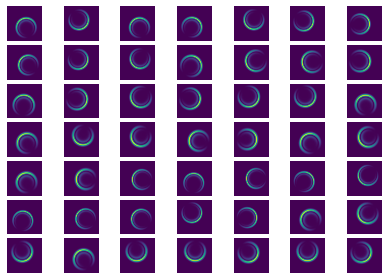

In [4]:
fig, ax_array = plt.subplots(7, 7)
axes = ax_array.flatten()
for i, ax in enumerate(axes):
    im, lab = training_data[i]
    ax.imshow(im[0])
plt.setp(axes, xticks=[], yticks=[], frame_on=False)
plt.tight_layout(h_pad=0.4, w_pad=0.0001)

Prepare a smaller subset all in RAM to perfrom PCA and UMAP on its samples!

In [5]:
num_images = 500
#random_indices = np.random.choice(range(len(training_data)), num_images, replace=False)
random_indices = np.random.choice(range(2850), num_images, replace=False)
X21 = training_data[0][0].shape[1]
x = np.zeros( (num_images, X21**2), dtype=np.float32)
y = np.zeros((num_images), dtype=np.float64)

for j,idx in enumerate(random_indices):
    im, lab = training_data[idx]
    x[j, :] = im[0].flatten()
    y[j] = lab   

df = pd.DataFrame({'y':y})
df['phiCR'] = df["y"].astype(str)

pip install umap-learn
pip install bokeh


# Test with PCA

In [6]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
df = pd.concat([principalDf, df], axis = 1)

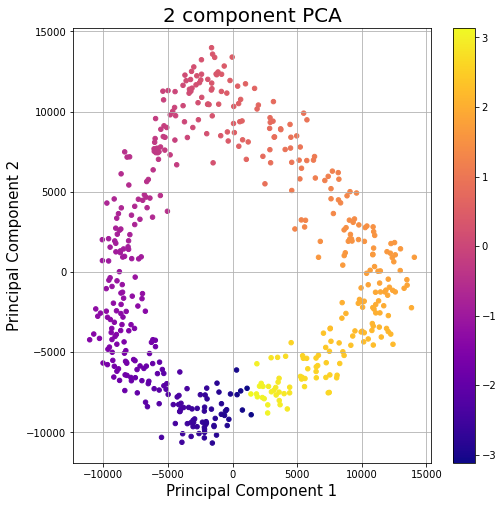

In [7]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)

points = ax.scatter(df['principal component 1']
               , df['principal component 2']
               , s = 20, c=y, cmap="plasma"
              )
fig.colorbar(points)

#ax.legend(targets)
ax.grid()

In [8]:
from io import BytesIO
from PIL import Image
import base64
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool, ColumnDataSource, LinearColorMapper
from bokeh.palettes import Spectral10

output_notebook()

def embeddable_image(data):
    img_data = data.values.reshape(X21,X21).astype(np.uint8)
    image = Image.fromarray(img_data, mode='L').resize((64, 64), Image.BICUBIC)
    buffer = BytesIO()
    image.save(buffer, format='png')
    for_encoding = buffer.getvalue()
    return 'data:image/png;base64,' + base64.b64encode(for_encoding).decode()

df['image'] = pd.DataFrame(data=x, columns=list(range(x.shape[1]))).apply(embeddable_image, axis=1)

datasource = ColumnDataSource(df)
color_mapping = LinearColorMapper(
    palette='Magma256',
    low=y.min(),
    high=y.max()
)

plot_figure = figure(
    title='PCA projection of the CR dataset',
    plot_width=800,
    plot_height=800,
    tools=('pan, wheel_zoom, reset')
)

plot_figure.add_tools(HoverTool(tooltips="""
<div>
    <div>
        <img src='@image' style='float: left; margin: 5px 5px 5px 5px'/>
    </div>
    <div>
        <span style='font-size: 16px; color: #224499'>Digit:</span>
        <span style='font-size: 18px'>@phiCR</span>
    </div>
</div>
"""))

plot_figure.circle(
    'principal component 1',
    'principal component 2',
    source=datasource,
    color=dict(field='phiCR', transform=color_mapping),
    line_alpha=0.6,
    fill_alpha=0.6,
    size=7
)
show(plot_figure)

Loading BokehJS ...

# Test with UMAP

In [9]:
from umap import UMAP

umap_reducer = UMAP(n_components=2, min_dist=0.1, n_neighbors=500, metric='euclidean')
principalComponents = umap_reducer.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['umap_1', 'umap_2'])
df = pd.concat([principalDf, df], axis = 1)

/home/melanie/anaconda3/envs/fbvars/lib/python3.7/site-packages/umap/umap_.py:2345: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  "n_neighbors is larger than the dataset size; truncating to "


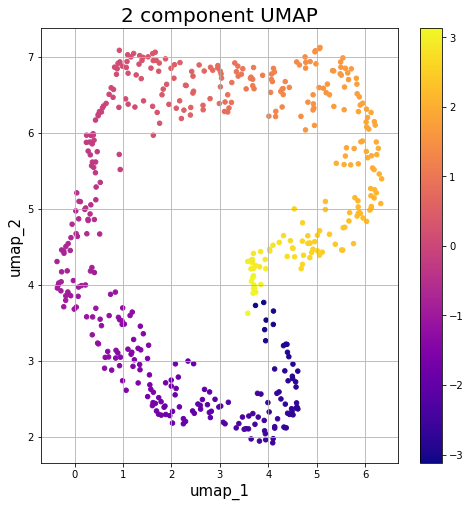

In [10]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('umap_1', fontsize = 15)
ax.set_ylabel('umap_2', fontsize = 15)
ax.set_title('2 component UMAP', fontsize = 20)

points = ax.scatter(df['umap_1']
               , df['umap_2']
               , s = 20, c=y, cmap="plasma"
              )
fig.colorbar(points)

ax.grid()

In [11]:
from io import BytesIO
from PIL import Image
import base64
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool, ColumnDataSource, LinearColorMapper
from bokeh.palettes import Spectral10

output_notebook()

def embeddable_image(data):
    img_data = data.values.reshape(X21,X21).astype(np.uint8)
    image = Image.fromarray(img_data, mode='L').resize((64, 64), Image.BICUBIC)
    buffer = BytesIO()
    image.save(buffer, format='png')
    for_encoding = buffer.getvalue()
    return 'data:image/png;base64,' + base64.b64encode(for_encoding).decode()

#df['image'] = pd.DataFrame({'image':x}).apply(embeddable_image, axis=1)


datasource = ColumnDataSource(df)
color_mapping = LinearColorMapper(
    palette='Magma256',
    low=y.min(),
    high=y.max()
)

plot_figure = figure(
    title='UMAP projection of the CR dataset',
    plot_width=800,
    plot_height=800,
    tools=('pan, wheel_zoom, reset')
)

plot_figure.add_tools(HoverTool(tooltips="""
<div>
    <div>
        <img src='@image' style='float: left; margin: 5px 5px 5px 5px'/>
    </div>
    <div>
        <span style='font-size: 16px; color: #224499'>Digit:</span>
        <span style='font-size: 18px'>@phiCR</span>
    </div>
</div>
"""))

plot_figure.circle(
    'umap_1',
    'umap_2',
    source=datasource,
    color=dict(field='phiCR', transform=color_mapping),
    line_alpha=0.6,
    fill_alpha=0.6,
    size=7
)
show(plot_figure)

Loading BokehJS ...

In [12]:
df

,umap_1,umap_2,principal component 1,principal component 2,y,phiCR,image
0,2.456082,6.545715,772.435486,8234.667969,0.611731,0.6117312908172607,"data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA..."
1,-0.340927,3.996810,-9598.227539,2069.144043,-0.873667,-0.8736667633056641,"data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA..."
2,3.697877,3.947746,2079.301025,-7127.209961,3.050670,3.0506703853607178,"data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA..."
3,2.852272,6.821888,2910.913574,9322.601562,0.773525,0.7735254764556885,"data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA..."
4,6.325661,5.067623,11912.394531,-3525.889893,2.116832,2.1168320178985596,"data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA..."
...,...,...,...,...,...,...,...
495,1.422345,6.418367,-2003.825806,8616.645508,0.221037,0.2210373878479004,"data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA..."
496,2.163166,2.393454,-7527.401855,-6598.047363,-1.882401,-1.8824012279510498,"data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA..."
497,0.464785,5.750324,-5579.020020,7787.816406,-0.252829,-0.25282931327819824,"data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA..."
498,5.575331,6.600521,10983.288086,331.176270,1.729385,1.7293846607208252,"data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA..."
